In [48]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

In [49]:
# Loading Data
data = pd.read_csv('D:\Master_Folder\Data Science Course\Projects\StockMarket\stock_data\SUZLON.NS_2023-01-01_to_2024-11-21_ML.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

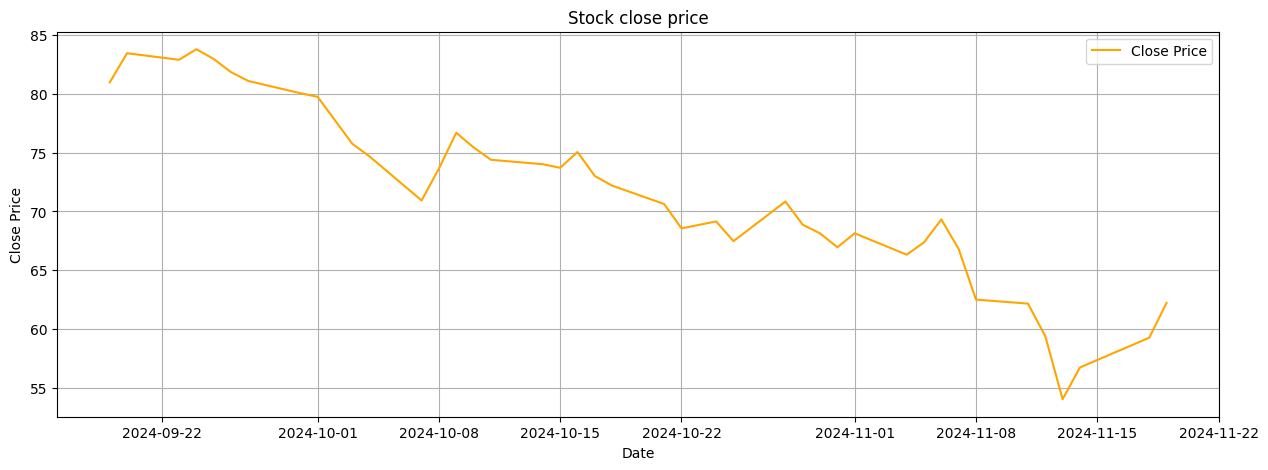

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Close'], label='Close Price', color = 'orange')
plt.title('Stock close price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

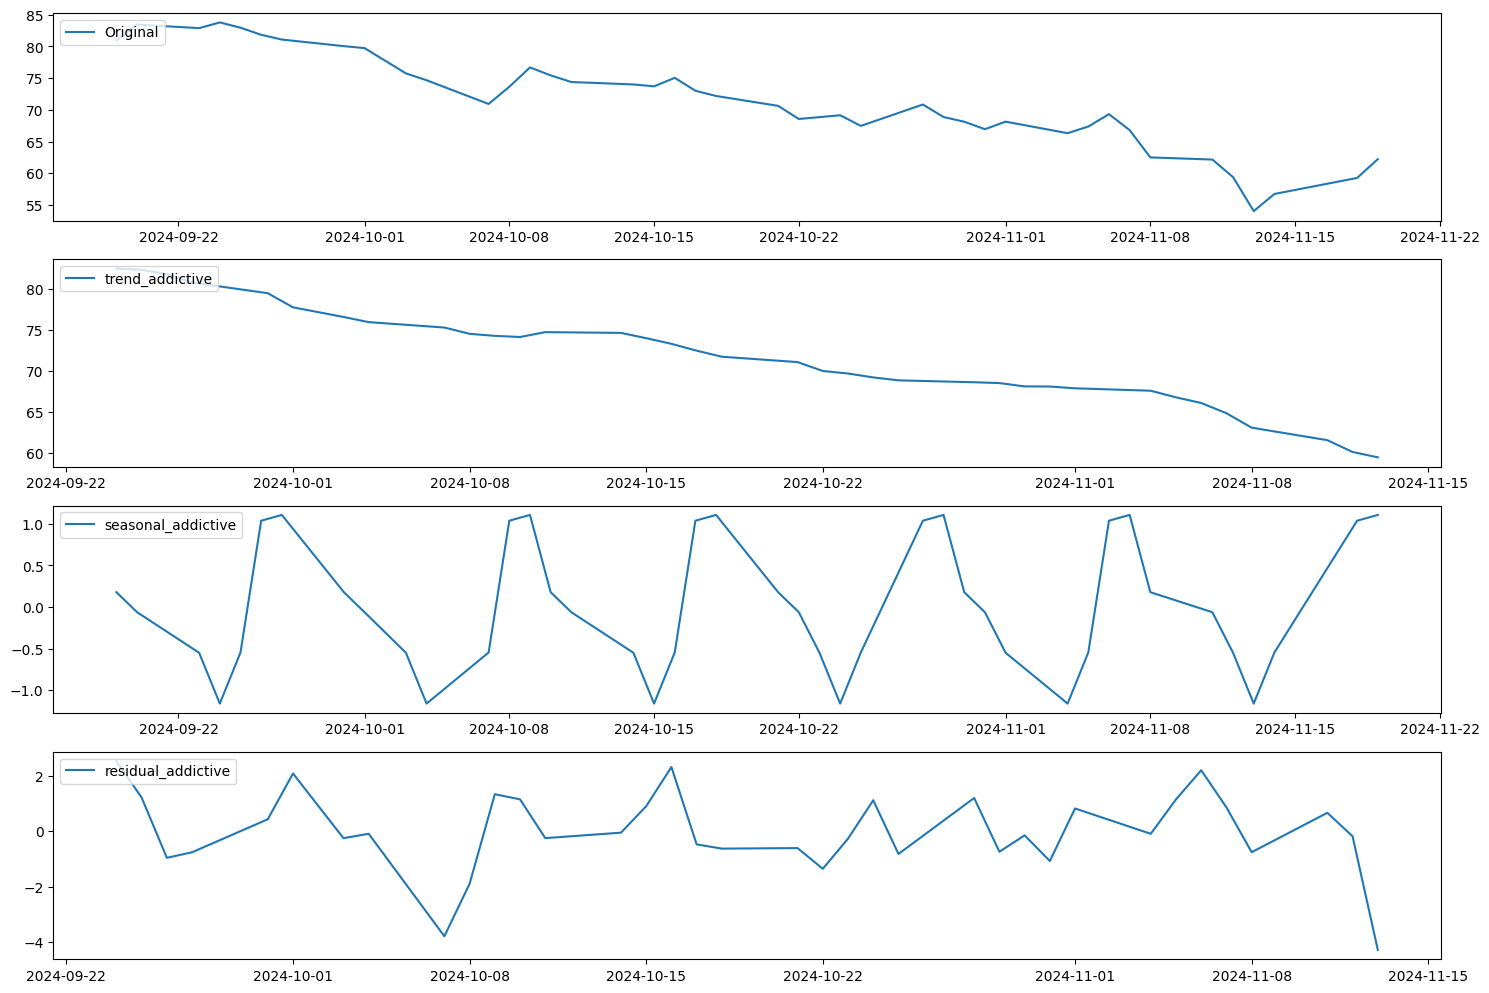

In [52]:
# Performing classical seasonal decomposition
decompose_addictive = seasonal_decompose(data['Close'], model='additive', period=7)

trend_addictive = decompose_addictive.trend 
seasonal_addictive = decompose_addictive.seasonal 
residual_addictive = decompose_addictive.resid 

plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(data['Close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_addictive, label='trend_addictive')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_addictive, label='seasonal_addictive')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_addictive, label='residual_addictive')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

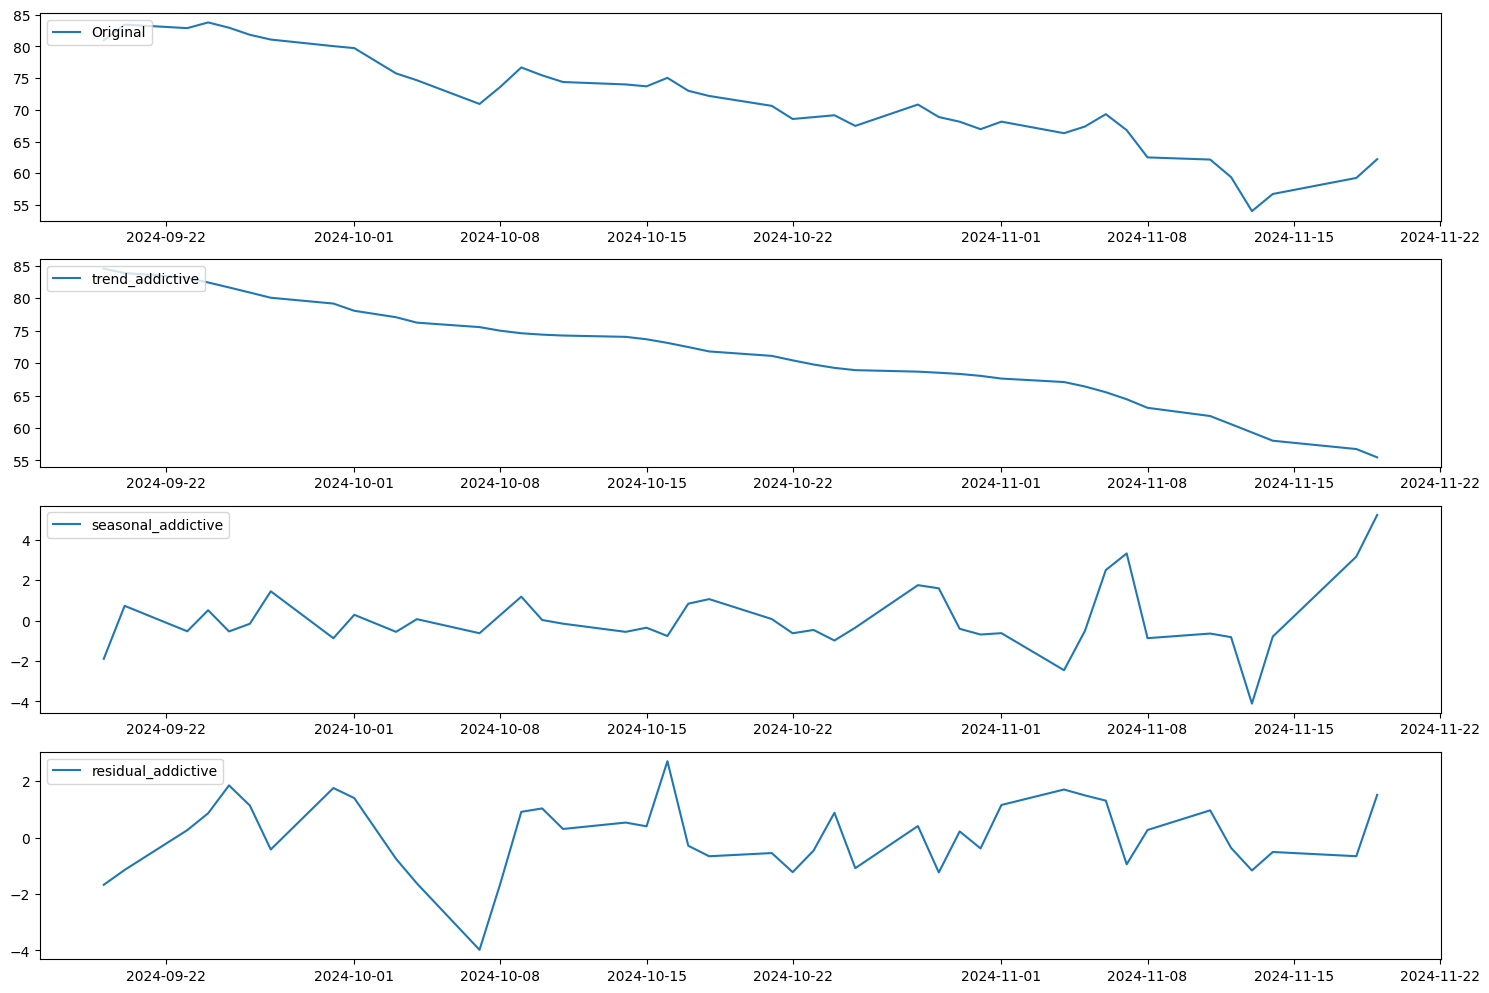

In [53]:
# Performing STL(LOESS) decomposition

stl = STL(data['Close'], period=7)
result = stl.fit()

plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='trend_addictive')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='seasonal_addictive')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='residual_addictive')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [54]:
def check_stationary(data):
    adf_test = adfuller(data)
    print("ADF Statistics: ", adf_test[0])
    print("P value: ", adf_test[1])
    if(adf_test[1] < 0.05):
        print("Data is stationary")
    else:
        print("Data is not stationary. Differencing required.")

In [55]:
check_stationary(data['Close'])

ADF Statistics:  -0.9264439380749445
P value:  0.7791393745323228
Data is not stationary. Differencing required.


In [56]:
data['Close_diff'] = data['Close'].diff()
data.dropna(inplace=True)

check_stationary(data['Close_diff'])

ADF Statistics:  -5.890440145408447
P value:  2.933082613873411e-07
Data is stationary


In [57]:
# Split data
train_size = int(len(data) * 0.7)
train = data['Close'][:train_size]
test = data['Close'][train_size:]

In [58]:
test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 13 entries, 2024-10-31 to 2024-11-19
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
13 non-null     float64
dtypes: float64(1)
memory usage: 208.0 bytes


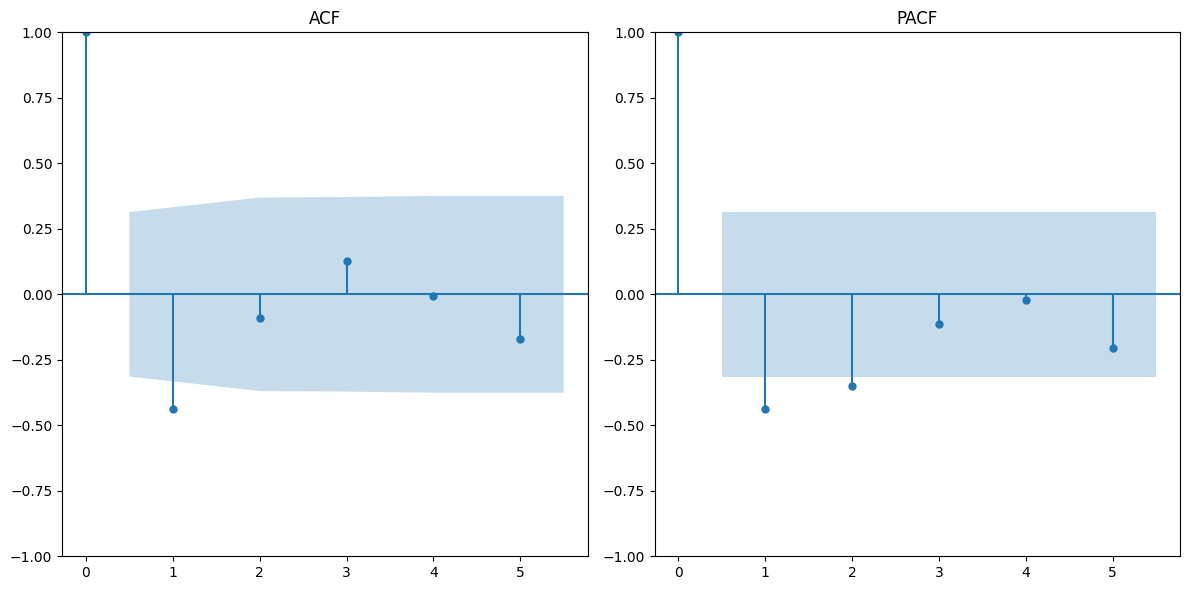

In [61]:
# ACF Plot
plt.figure(figsize=(12,6))
plt.subplot(1,2, 1)
plot_acf(data['Close'].diff().diff().dropna(), ax=plt.gca(), lags=5)
plt.title('ACF')
# PACF Plot
plt.subplot(1,2, 2)
plot_pacf(data['Close'].diff().diff().dropna(), ax=plt.gca(), lags=5, method='ywm')
plt.title('PACF')

plt.tight_layout()
plt.show()

In [67]:
model = ARIMA(train, order=(1,2,2))
model_fit = model.fit()


In [68]:
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

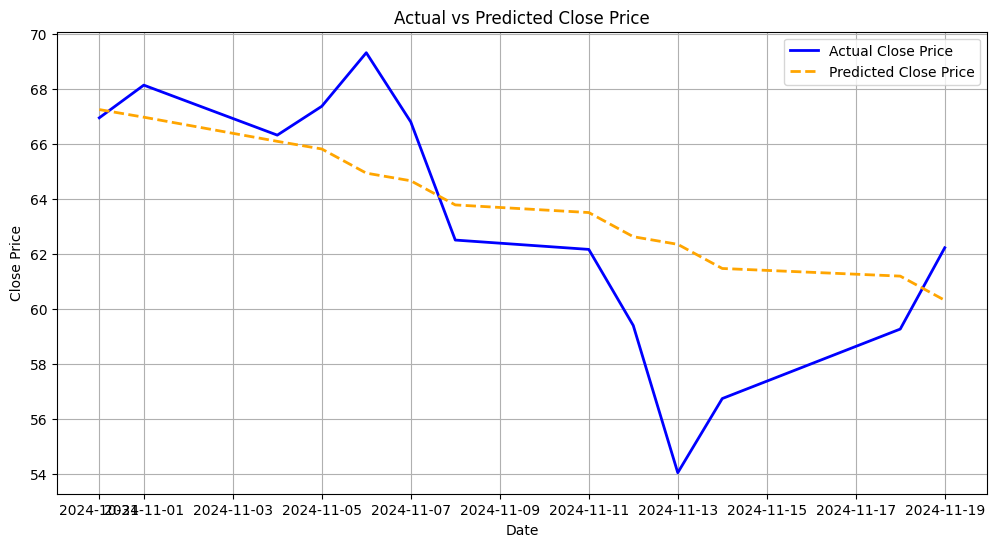

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Close Price", color='blue', linewidth=2)
plt.plot(test.index, predictions, label="Predicted Close Price", color='orange', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Use Auto ARIMA to find the best parameters
print("Running Auto ARIMA...")
auto_model = auto_arima(
    train,
    seasonal=True,           # Set to True for SARIMA
    m=7,                    # Frequency of seasonality (e.g., 12 for monthly)
    trace=True,              # Enables output of parameter tuning progress
    error_action='ignore',   # Silences warnings on invalid combinations
    suppress_warnings=True,  # Suppresses convergence warnings
    stepwise=True,           # Faster search
    max_order=20             # Limits the sum of (p+q) for ARIMA
)

# Summary of the best model
print("Best Model Summary:")
print(auto_model.summary())

# Forecast on the test data
forecast = auto_model.predict(n_periods=len(test))

Running Auto ARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=109.564, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=111.100, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=111.282, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=110.387, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=109.539, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=111.354, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=111.385, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=109.838, Time=0.04 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=113.319, Time=0.54 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=110.989, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=111.748, Time=0.04 sec

Best model:  ARIMA(0,1,0)(1,0,0)[7] intercept
Total fit time: 2.280 seconds
Best Model Summary:
 

MSE: 10.3741
MAE: 2.4498
MAPE: nan%


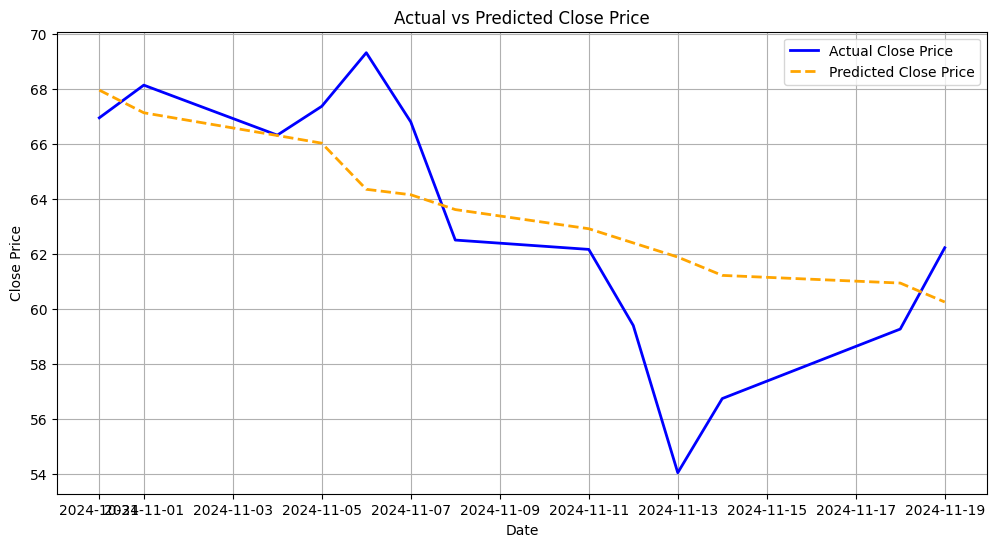

In [71]:
# Evaluate
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
mape = (np.abs((test - forecast) / test).mean()) * 100

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Close Price", color='blue', linewidth=2)
plt.plot(test.index, forecast, label="Predicted Close Price", color='orange', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()